In [1]:
import ginsim
import biolqm
import maboss

# Model of CD8+ T cell activation

The model was designed to study the interaction between the redox state and cellular metabolism and its influence on the activation of human CD8+ T lymphocytes.

The model for the TCR-REDOX-METABOLISM signaling was constructed using the software GINsim (http://ginsim.org). In the logical regulatory graph, each node represents a component of the signaling network. Most nodes are Boolean (ellipses), but some have three levels of activity, 0, 1 and 2 (rectangles). Nodes are connected through arcs, which represent the regulatory influences between them, positive (green) or negative (red). A logical rule is defined for each node to determine the level of activity of the target node as a function of the levels of its regulators.

In [2]:
# Load the model
lrg = ginsim.load("http://ginsim.org/sites/default/files/TCR-REDOX-METABOLISM_2019-07-26_reduced_0.zginml")

# Booleanize the model for integration with MaBoSS
lqm = biolqm.booleanize( ginsim.to_biolqm(lrg) )

# Convert to MaBoSS for stochastic simulations
mbs = biolqm.to_maboss(lqm)
maboss.set_output(mbs, ["QUIESCENCE", "ACTIVATION", "ANERGY", "METABOLIC_ANERGY"])
maboss.set_nodes_istate(mbs, mbs.network.names, [1,0])

Downloading 'http://ginsim.org/sites/default/files/TCR-REDOX-METABOLISM_2019-07-26_reduced_0.zginml'

The model integrates 111 molecular components and 247 cross-interactions. It includes two inputs, the TCR and CD28 signals. Second messengers, as well as mROS and cROS were also considered, together with key components of the Krebs Cycle, Electron Transport Chain, Fatty acids Oxidation, Glutaminolysis, Pentoses, Fatty Acid Synthesis and Glycolysis metabolic pathways.  Selected transcription factors link these pathways to cell responses, such as Activation, Quiescence (dormant cells), Anergy (incomplete activation of transcription factors) and Metabolic Anergy (unbalanced metabolism, only aerobic glycolysis without mitochondrial oxidation).  We also included IL-2 and CD69 as early activation markers.

Given the content of the model, stable state analysis allows us to find the asymptotic behaviour of the model in different biological contexts.

# Behaviour in absence of stimulation

## Stable states

In a first time, we can compute the stable states observable in absence of TCR stimulation.

In [3]:
# Find fixed points, also called stable states
fps = biolqm.states_to_dataframe( biolqm.fixpoints(lqm, autoconvert=False) )

# Focus on the stable states corresponding to an absence of TCR stimulation
fps_basal = fps[fps['TCR']==0]
fps_basal

,TCR,CD28,PKCTH,SHP2,PTEN,RAS,mCa_b1,mCa_b2,mROS_b1,mROS_b2,...,FOXO,AP1,NFkB,NFAT,IL2,CD69,QUIESCENCE,ACTIVATION,ANERGY,METABOLIC_ANERGY
0,0,0,0,0,0,0,1,1,1,1,...,0,0,0,1,0,0,0,0,1,1
1,0,1,0,0,0,0,1,1,1,1,...,0,0,0,1,0,0,0,0,1,1
2,0,0,0,1,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,0,1,0,1,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


The previous table shows the computation of the four stable states of the model in the case of no TCR stimulation. Each column represents the level of activity for the defined node, 0 means no activity and 1 means maximal level of activity.

The stable states 2 and 3 (only different on the level of activity for the node CD28) recapitulate the case of the adult CD8+ T cells before stimulation, with low levels of ROS production, low cytoplasmic and mitochondrial calcium levels, low levels of aerobic glycolysis and normal mitochondrial oxidative activity.

The stable states 0 and 1 (only different on the level of activity for the node CD28) recapitulate the case of the neonatal CD8+ T cells before stimulation, with high ROS production, high cytoplasmic and mitochondrial calcium levels, high levels of aerobic glycolysis and altered mitochondrial oxidative activity.

## Reachability analysis (stochastic simulation)

Starting with the inactivated stable states (TCR=0), evaluate the reached phenotype.

In [4]:
# Define a function for simulations in various conditions
def perform_simulation(title, model, active_nodes=None, until=30):
    mbs = model.copy()
    if active_nodes:
        maboss.set_nodes_istate(mbs, active_nodes, [0,1])
    print("# Running:", title)
    simres = mbs.run()
    print("Entropy (TH) at time point %s :" % until)
    print(simres.get_entropy_trajectory().iloc[until+1]) # TH should reach 0 for convergence
    simres.plot_piechart()
    simres.plot_node_trajectory(until=until)

# Running: No TCR stimulation
Entropy (TH) at time point 30 :
TH    0.0000
H     0.1082
Name: 31, dtype: float64


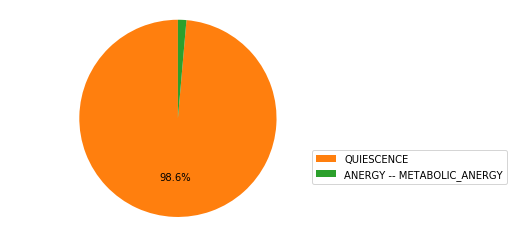

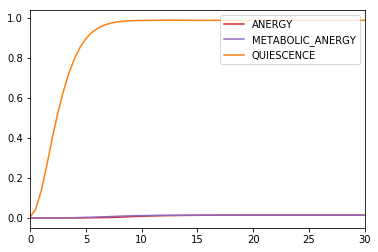

In [5]:
perform_simulation("No TCR stimulation", mbs)

# Running: No TCR stimulation, High mROS
Entropy (TH) at time point 30 :
TH    0.0000
H     0.9101
Name: 31, dtype: float64


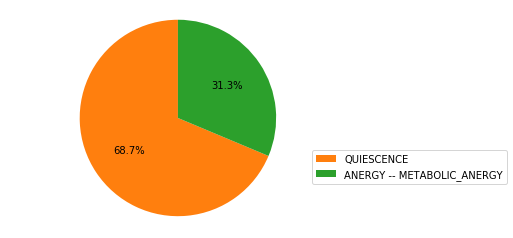

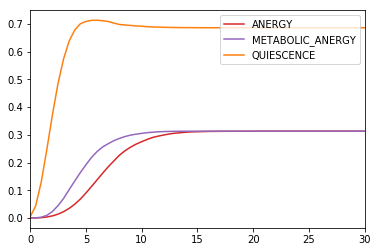

In [6]:
perform_simulation("No TCR stimulation, High mROS", mbs, ["mROS_b1", "mROS_b2"])

# Running: No TCR stimulation, High cROS
Entropy (TH) at time point 30 :
TH    0.0000
H     0.8753
Name: 31, dtype: float64


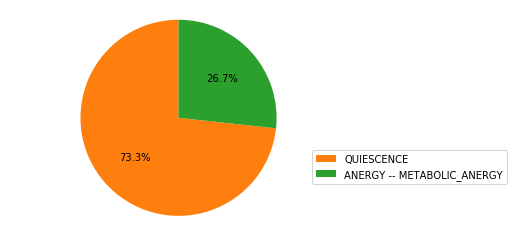

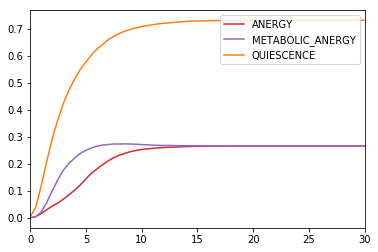

In [7]:
perform_simulation("No TCR stimulation, High cROS", mbs, ["cROS_b1", "cROS_b2"])

# Behaviour during stimulation

## Stable states

In a second time, we can compute the stable states observable during TCR stimulation.

In [8]:
# Find fixed points, also called stable states
fps = biolqm.states_to_dataframe( biolqm.fixpoints(lqm, autoconvert=False) )
# Focus on the stable states corresponding to an absence of TCR stimulation
fps_stimul = fps[(fps['TCR']==1) & (fps['CD28']==1)]
fps_stimul

,TCR,CD28,PKCTH,SHP2,PTEN,RAS,mCa_b1,mCa_b2,mROS_b1,mROS_b2,...,FOXO,AP1,NFkB,NFAT,IL2,CD69,QUIESCENCE,ACTIVATION,ANERGY,METABOLIC_ANERGY
7,1,1,0,0,0,0,1,1,1,1,...,0,0,0,1,0,0,0,0,1,0
8,1,1,1,0,0,1,1,1,1,0,...,0,1,1,1,1,1,0,1,0,0


The previous table shows the computation of the two stable states of the model in the case of TCR/CD28 stimulation. Each column represents the level of activity for the defined node, 0 means no activity and 1 means maximal level of activity.

The stable state 8 recapitulates the case of the adult CD8+ T cells upon stimulation, with low levels of ROS production, high cytoplasmic and mitochondrial calcium levels, and a metabolic shift towards high aerobic glycolysis combined with low mitochondrial oxidative activity, favoring T cell activation and proliferation.

The stable state 7 recapitulates the case of the neonatal CD8+ T cells upon stimulation, with high ROS production, high cytoplasmic and mitochondrial calcium levels, high levels of aerobic glycolysis and altered mitochondrial oxidative activity, which impairs proper activation and mantain the cells in a state of anergy.

## Reachability analysis (stochastic simulation)

Starting with TCR=1, evaluate the reached phenotype after adding TCR and flipping mROS.

# Running: TCR stimulation
Entropy (TH) at time point 30 :
TH    0.0019
H     1.3781
Name: 31, dtype: float64


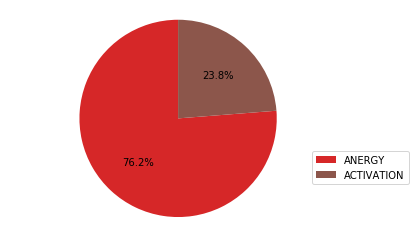

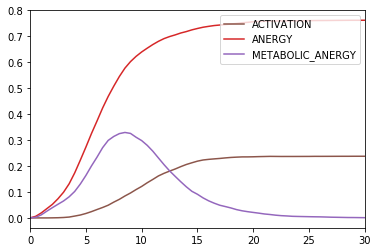

In [9]:
perform_simulation("TCR stimulation", mbs, ["TCR", "CD28"])

# Running: TCR stimulation, High mROS
Entropy (TH) at time point 30 :
TH    0.0017
H     1.0518
Name: 31, dtype: float64


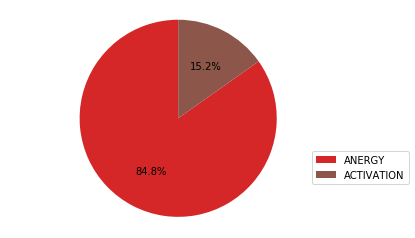

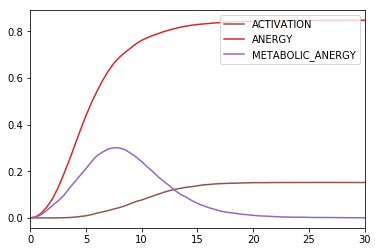

In [10]:
perform_simulation("TCR stimulation, High mROS", mbs, ["TCR", "CD28", "mROS_b1", "mROS_b2"])

# Running: TCR stimulation, High cROS
Entropy (TH) at time point 30 :
TH    0.0019
H     1.0680
Name: 31, dtype: float64


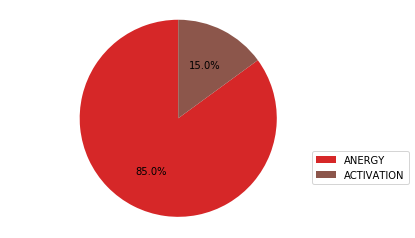

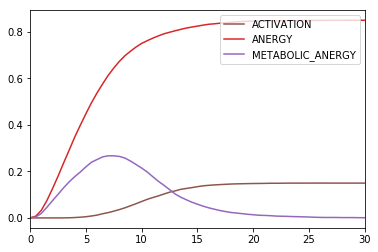

In [11]:
perform_simulation("TCR stimulation, High cROS", mbs, ["TCR", "CD28", "cROS_b1", "cROS_b2"])